## **Fraud Detection**

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [207]:
df = pd.read_csv("synthetic_fraud_dataset.csv")

In [208]:
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


#### **Preprocessing of Data**

In [209]:
df=df.drop('Transaction_ID', axis=1)
df.head()

,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [210]:
user_stats = df.groupby('User_ID').agg({
    'Transaction_Amount': ['mean', 'std', 'max', 'count'],
    'Fraud_Label': 'sum',
    'Daily_Transaction_Count': 'mean'
}).reset_index()
user_stats.columns = ['User_ID', 'avg_trans_amount', 'std_trans_amount', 
                      'max_trans_amount', 'total_transactions', 
                      'total_fraud', 'avg_daily_transactions']

In [211]:
df = df.merge(user_stats, on='User_ID', how='left')
df['amount_deviation'] = (df['Transaction_Amount'] - df['avg_trans_amount']) / (df['std_trans_amount'] + 1e-6)

In [212]:
mean_txn_per_user = df.groupby('User_ID').size().mean() # calculates the average number of transactions per user in your dataset.
df['user_transaction_count'] = df.groupby('User_ID')['User_ID'].transform('count')
df['high_activity_user'] = df['user_transaction_count'] > (2 * mean_txn_per_user)


In [213]:
df.head()

,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,...,Fraud_Label,avg_trans_amount,std_trans_amount,max_trans_amount,total_transactions,total_fraud,avg_daily_transactions,amount_deviation,user_transaction_count,high_activity_user
0,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,0,...,0,106.767143,76.634812,233.65,7,0,11.142857,-0.873978,7,False
1,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,0,...,1,11.688000,9.997356,26.47,5,1,9.000000,-1.050078,5,False
2,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,0,...,1,55.782500,72.871105,164.54,4,2,11.500000,-0.368081,4,False
3,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,0,...,1,161.852222,92.498248,354.77,9,1,8.333333,0.999671,9,False
4,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,1,...,1,71.240000,77.264438,249.88,9,4,6.333333,-0.517185,9,False


In [214]:
df['high_activity_user'].value_counts()

high_activity_user
False    48571
True      1429
Name: count, dtype: int64

In [215]:
df['high_activity_user']=df['high_activity_user'].astype(int)
df.head()

,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,...,Fraud_Label,avg_trans_amount,std_trans_amount,max_trans_amount,total_transactions,total_fraud,avg_daily_transactions,amount_deviation,user_transaction_count,high_activity_user
0,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,0,...,0,106.767143,76.634812,233.65,7,0,11.142857,-0.873978,7,0
1,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,0,...,1,11.688000,9.997356,26.47,5,1,9.000000,-1.050078,5,0
2,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,0,...,1,55.782500,72.871105,164.54,4,2,11.500000,-0.368081,4,0
3,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,0,...,1,161.852222,92.498248,354.77,9,1,8.333333,0.999671,9,0
4,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,1,...,1,71.240000,77.264438,249.88,9,4,6.333333,-0.517185,9,0


In [216]:
df['Merchant_Category'].value_counts()

Merchant_Category
Clothing       10033
Groceries      10019
Travel         10015
Restaurants     9976
Electronics     9957
Name: count, dtype: int64

In [217]:
# hot encoding layer of 'Merchant Category'
pd.get_dummies(df['Merchant_Category'], prefix='Merchant_Category', dtype=int).head()
df = pd.concat([df, pd.get_dummies(df['Merchant_Category'], prefix='Merchant_Category', dtype=int)], axis=1)
df = df.drop('Merchant_Category', axis=1)

In [218]:
df.head()

,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,...,total_fraud,avg_daily_transactions,amount_deviation,user_transaction_count,high_activity_user,Merchant_Category_Clothing,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel
0,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,0,0,7,...,0,11.142857,-0.873978,7,0,0,0,0,0,1
1,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,0,0,13,...,1,9.000000,-1.050078,5,0,1,0,0,0,0
2,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,0,0,14,...,2,11.500000,-0.368081,4,0,0,0,0,1,0
3,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,0,0,8,...,1,8.333333,0.999671,9,0,1,0,0,0,0
4,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,0,1,14,...,4,6.333333,-0.517185,9,0,0,1,0,0,0


In [219]:
df['Device_Type'].value_counts()

Device_Type
Tablet    16779
Mobile    16640
Laptop    16581
Name: count, dtype: int64

In [220]:
df=pd.concat([df,pd.get_dummies(df['Device_Type'],prefix='Device_Type',dtype=int)],axis=1)
df.head()

,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,...,user_transaction_count,high_activity_user,Merchant_Category_Clothing,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Device_Type_Laptop,Device_Type_Mobile,Device_Type_Tablet
0,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,0,0,7,...,7,0,0,0,0,0,1,1,0,0
1,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,0,0,13,...,5,0,1,0,0,0,0,0,1,0
2,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,0,0,14,...,4,0,0,0,0,1,0,0,0,1
3,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,0,0,8,...,9,0,1,0,0,0,0,0,0,1
4,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,0,1,14,...,9,0,0,1,0,0,0,0,1,0


In [221]:
df.drop('Device_Type', axis=1, inplace=True)
df.head()

,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,...,user_transaction_count,high_activity_user,Merchant_Category_Clothing,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Device_Type_Laptop,Device_Type_Mobile,Device_Type_Tablet
0,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,437.63,...,7,0,0,0,0,0,1,1,0,0
1,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,New York,0,0,13,478.76,...,5,0,1,0,0,0,0,0,1,0
2,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,50.01,...,4,0,0,0,0,1,0,0,0,1
3,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,New York,0,0,8,182.48,...,9,0,1,0,0,0,0,0,0,1
4,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,328.69,...,9,0,0,1,0,0,0,0,1,0


In [222]:
df['Transaction_Type'].value_counts()

Transaction_Type
POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: count, dtype: int64

In [223]:
df=pd.concat([df, pd.get_dummies(df['Transaction_Type'], prefix='Transaction_Type', dtype=int)], axis=1)
df.drop('Transaction_Type', axis=1, inplace=True)
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,...,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Device_Type_Laptop,Device_Type_Mobile,Device_Type_Tablet,Transaction_Type_ATM Withdrawal,Transaction_Type_Bank Transfer,Transaction_Type_Online,Transaction_Type_POS
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,437.63,3,...,0,0,1,1,0,0,0,0,0,1
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,478.76,4,...,0,0,0,0,1,0,0,1,0,0
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,50.01,4,...,0,1,0,0,0,1,0,0,1,0
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,182.48,4,...,0,0,0,0,0,1,1,0,0,0
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,328.69,4,...,0,0,0,0,1,0,0,0,0,1


In [224]:
df['Card_Type'].value_counts()

Card_Type
Mastercard    12693
Visa          12560
Amex          12419
Discover      12328
Name: count, dtype: int64

In [225]:
df=pd.concat([df, pd.get_dummies(df['Card_Type'], prefix='Card_Type', dtype=int)], axis=1)
df.drop('Card_Type', axis=1, inplace=True)
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,...,Device_Type_Mobile,Device_Type_Tablet,Transaction_Type_ATM Withdrawal,Transaction_Type_Bank Transfer,Transaction_Type_Online,Transaction_Type_POS,Card_Type_Amex,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,437.63,3,...,0,0,0,0,0,1,1,0,0,0
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,478.76,4,...,1,0,0,1,0,0,0,0,1,0
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,50.01,4,...,0,1,0,0,1,0,0,0,0,1
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,182.48,4,...,0,1,1,0,0,0,0,0,0,1
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,328.69,4,...,1,0,0,0,0,1,0,0,1,0


In [226]:
df['Card_Age'].min()
df['Card_Age'].max()

np.int64(239)

In [227]:
df['Card_Age']=pd.cut(
    df['Card_Age'],
    bins=[0, 6, 24, 60, 240],
    labels=['very_new', 'new', 'established', 'veteran']
)

In [228]:
df.head()


,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,...,Device_Type_Mobile,Device_Type_Tablet,Transaction_Type_ATM Withdrawal,Transaction_Type_Bank Transfer,Transaction_Type_Online,Transaction_Type_POS,Card_Type_Amex,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,437.63,3,...,0,0,0,0,0,1,1,0,0,0
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,478.76,4,...,1,0,0,1,0,0,0,0,1,0
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,50.01,4,...,0,1,0,0,1,0,0,0,0,1
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,182.48,4,...,0,1,1,0,0,0,0,0,0,1
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,328.69,4,...,1,0,0,0,0,1,0,0,1,0


In [229]:
df=pd.concat([df, pd.get_dummies(df['Card_Age'], prefix='card_age', dtype=int)], axis=1)
df.drop('Card_Age', axis=1, inplace=True)
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,...,Transaction_Type_Online,Transaction_Type_POS,Card_Type_Amex,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,card_age_very_new,card_age_new,card_age_established,card_age_veteran
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,437.63,3,...,0,1,1,0,0,0,0,0,0,1
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,478.76,4,...,0,0,0,0,1,0,0,0,0,1
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,50.01,4,...,1,0,0,0,0,1,0,0,0,1
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,182.48,4,...,0,0,0,0,0,1,0,0,0,1
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,328.69,4,...,0,1,0,0,1,0,0,0,0,1


In [230]:
df['Avg_Transaction_Amount_7d'].min()
# df['Avg_Transaction_Amount_7d'].max()

np.float64(10.0)

In [231]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Avg_Transaction_Amount_7d_Scaled'] = scaler.fit_transform(df[['Avg_Transaction_Amount_7d']])


In [232]:
df.drop('Avg_Transaction_Amount_7d', axis=1, inplace=True)
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,Transaction_Type_POS,Card_Type_Amex,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,card_age_very_new,card_age_new,card_age_established,card_age_veteran,Avg_Transaction_Amount_7d_Scaled
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,1,1,0,0,0,0,0,0,1,0.872714
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0,0,0,1,0,0,0,0,1,0.956653
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,0,0,0,1,0,0,0,1,0.081653
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,0,0,0,1,0,0,0,1,0.352000
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,1,0,0,1,0,0,0,0,1,0.650388


In [233]:
df['Failed_Transaction_Count_7d'].value_counts()

Failed_Transaction_Count_7d
3    10216
0    10014
4     9954
1     9919
2     9897
Name: count, dtype: int64

In [234]:
df['Failed_Transaction_Count_7d_Scaled'] = scaler.fit_transform(df[['Failed_Transaction_Count_7d']]) # feature scaling

In [235]:
df['has_failed_transaction'] = (df['Failed_Transaction_Count_7d'] > 0).astype(int)
df['failurerate_7d'] = df['Failed_Transaction_Count_7d'] / (df['Daily_Transaction_Count'] + 1) # we add 1 to davoid divide by zero 

In [236]:
df.head()


,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,Card_Type_Mastercard,Card_Type_Visa,card_age_very_new,card_age_new,card_age_established,card_age_veteran,Avg_Transaction_Amount_7d_Scaled,Failed_Transaction_Count_7d_Scaled,has_failed_transaction,failurerate_7d
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0,0,0,0,0,1,0.872714,0.75,1,0.375000
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,1,0,0,0,0,1,0.956653,1.00,1,0.285714
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,1,0,0,0,1,0.081653,1.00,1,0.266667
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,1,0,0,0,1,0.352000,1.00,1,0.444444
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,1,0,0,0,0,1,0.650388,1.00,1,0.266667


In [237]:
df['User_Transaction_Deviation'] = df['user_transaction_count'] - mean_txn_per_user
df['User_Transaction_Deviation_Scaled'] = df['User_Transaction_Deviation'] / (df['user_transaction_count'].max())
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,card_age_very_new,card_age_new,card_age_established,card_age_veteran,Avg_Transaction_Amount_7d_Scaled,Failed_Transaction_Count_7d_Scaled,has_failed_transaction,failurerate_7d,User_Transaction_Deviation,User_Transaction_Deviation_Scaled
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0,0,0,1,0.872714,0.75,1,0.375000,1.421511,0.088844
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0,0,0,1,0.956653,1.00,1,0.285714,-0.578489,-0.036156
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,0,0,1,0.081653,1.00,1,0.266667,-1.578489,-0.098656
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,0,0,1,0.352000,1.00,1,0.444444,3.421511,0.213844
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,0,0,0,1,0.650388,1.00,1,0.266667,3.421511,0.213844


In [238]:
df['Is_Weekend'].value_counts()

Is_Weekend
0    35018
1    14982
Name: count, dtype: int64

In [239]:
df['Is_Weekend']=df['Is_Weekend'].astype(int)
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,card_age_very_new,card_age_new,card_age_established,card_age_veteran,Avg_Transaction_Amount_7d_Scaled,Failed_Transaction_Count_7d_Scaled,has_failed_transaction,failurerate_7d,User_Transaction_Deviation,User_Transaction_Deviation_Scaled
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0,0,0,1,0.872714,0.75,1,0.375000,1.421511,0.088844
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0,0,0,1,0.956653,1.00,1,0.285714,-0.578489,-0.036156
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,0,0,1,0.081653,1.00,1,0.266667,-1.578489,-0.098656
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,0,0,1,0.352000,1.00,1,0.444444,3.421511,0.213844
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,0,0,0,1,0.650388,1.00,1,0.266667,3.421511,0.213844


In [240]:
df.columns

Index(['User_ID', 'Transaction_Amount', 'Timestamp', 'Account_Balance',
       'Location', 'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Failed_Transaction_Count_7d',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Fraud_Label', 'avg_trans_amount', 'std_trans_amount',
       'max_trans_amount', 'total_transactions', 'total_fraud',
       'avg_daily_transactions', 'amount_deviation', 'user_transaction_count',
       'high_activity_user', 'Merchant_Category_Clothing',
       'Merchant_Category_Electronics', 'Merchant_Category_Groceries',
       'Merchant_Category_Restaurants', 'Merchant_Category_Travel',
       'Device_Type_Laptop', 'Device_Type_Mobile', 'Device_Type_Tablet',
       'Transaction_Type_ATM Withdrawal', 'Transaction_Type_Bank Transfer',
       'Transaction_Type_Online', 'Transaction_Type_POS', 'Card_Type_Amex',
       'Card_Type_Discover', 'Card_Type_Mastercard', 'Card_Type_Visa',
       'ca

In [241]:
df['Previous_Fraudulent_Activity'].value_counts()

Previous_Fraudulent_Activity
0    45080
1     4920
Name: count, dtype: int64

In [242]:
df['account_balanced_scaled'] = scaler.fit_transform(df[['Account_Balance']]) # essential for logistic regression , neural network
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,card_age_new,card_age_established,card_age_veteran,Avg_Transaction_Amount_7d_Scaled,Failed_Transaction_Count_7d_Scaled,has_failed_transaction,failurerate_7d,User_Transaction_Deviation,User_Transaction_Deviation_Scaled,account_balanced_scaled
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0,0,1,0.872714,0.75,1,0.375000,1.421511,0.088844,0.931806
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0,0,1,0.956653,1.00,1,0.285714,-0.578489,-0.036156,0.756044
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,0,1,0.081653,1.00,1,0.266667,-1.578489,-0.098656,0.010940
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,0,1,0.352000,1.00,1,0.444444,3.421511,0.213844,0.766918
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,0,0,1,0.650388,1.00,1,0.266667,3.421511,0.213844,0.923178


In [243]:
df['balance_to_avg_transaction'] = df['Account_Balance'] / (df['avg_trans_amount'] + 1)
df['High_Balance_Flag'] = (df['Account_Balance'] > 100000).astype(int)
df['Low_Balance_Flag'] = (df['Account_Balance'] < 100).astype(int)
df.head()


,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,Avg_Transaction_Amount_7d_Scaled,Failed_Transaction_Count_7d_Scaled,has_failed_transaction,failurerate_7d,User_Transaction_Deviation,User_Transaction_Deviation_Scaled,account_balanced_scaled,balance_to_avg_transaction,High_Balance_Flag,Low_Balance_Flag
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0.872714,0.75,1,0.375000,1.421511,0.088844,0.931806,864.949812,0,0
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0.956653,1.00,1,0.285714,-0.578489,-0.036156,0.756044,5968.257409,0,0
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0.081653,1.00,1,0.266667,-1.578489,-0.098656,0.010940,27.983269,0,0
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0.352000,1.00,1,0.444444,3.421511,0.213844,0.766918,471.637408,0,0
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,0.650388,1.00,1,0.266667,3.421511,0.213844,0.923178,1278.442137,0,0


In [244]:
df.columns

Index(['User_ID', 'Transaction_Amount', 'Timestamp', 'Account_Balance',
       'Location', 'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Failed_Transaction_Count_7d',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Fraud_Label', 'avg_trans_amount', 'std_trans_amount',
       'max_trans_amount', 'total_transactions', 'total_fraud',
       'avg_daily_transactions', 'amount_deviation', 'user_transaction_count',
       'high_activity_user', 'Merchant_Category_Clothing',
       'Merchant_Category_Electronics', 'Merchant_Category_Groceries',
       'Merchant_Category_Restaurants', 'Merchant_Category_Travel',
       'Device_Type_Laptop', 'Device_Type_Mobile', 'Device_Type_Tablet',
       'Transaction_Type_ATM Withdrawal', 'Transaction_Type_Bank Transfer',
       'Transaction_Type_Online', 'Transaction_Type_POS', 'Card_Type_Amex',
       'Card_Type_Discover', 'Card_Type_Mastercard', 'Card_Type_Visa',
       'ca

In [245]:
df['Risk_Score'].value_counts()

Risk_Score
0.6917    16
0.3606    15
0.2990    15
0.9781    14
0.2228    14
          ..
0.4741     1
0.5626     1
0.3965     1
0.9968     1
0.3527     1
Name: count, Length: 9931, dtype: int64

In [246]:
df['Authentication_Method'].value_counts()

Authentication_Method
Biometric    12591
PIN          12586
Password     12457
OTP          12366
Name: count, dtype: int64

In [247]:
df=pd.concat([df, pd.get_dummies(df['Authentication_Method'], prefix='Auth_Method', dtype=int)], axis=1)

In [248]:
df.drop('Authentication_Method', axis=1, inplace=True)
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,User_Transaction_Deviation,User_Transaction_Deviation_Scaled,account_balanced_scaled,balance_to_avg_transaction,High_Balance_Flag,Low_Balance_Flag,Auth_Method_Biometric,Auth_Method_OTP,Auth_Method_PIN,Auth_Method_Password
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,1.421511,0.088844,0.931806,864.949812,0,0,1,0,0,0
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,-0.578489,-0.036156,0.756044,5968.257409,0,0,0,0,0,1
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,-1.578489,-0.098656,0.010940,27.983269,0,0,1,0,0,0
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,3.421511,0.213844,0.766918,471.637408,0,0,0,1,0,0
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,3.421511,0.213844,0.923178,1278.442137,0,0,0,0,0,1


In [249]:
df['Transaction_Distance'].value_counts()

Transaction_Distance
1743.63    4
951.92     4
127.17     3
507.33     3
3048.71    3
          ..
2768.44    1
999.06     1
330.48     1
1923.21    1
4436.61    1
Name: count, Length: 47546, dtype: int64

In [250]:
df['Location'].value_counts()

Location
Tokyo       10208
Mumbai       9994
London       9945
Sydney       9938
New York     9915
Name: count, dtype: int64

In [251]:
df=pd.concat([df, pd.get_dummies(df['Location'], prefix='Location', dtype=int)], axis=1)


In [252]:
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,Low_Balance_Flag,Auth_Method_Biometric,Auth_Method_OTP,Auth_Method_PIN,Auth_Method_Password,Location_London,Location_Mumbai,Location_New York,Location_Sydney,Location_Tokyo
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0,1,0,0,0,0,0,0,1,0
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0,0,0,0,1,0,0,1,0,0
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,1,0,0,0,0,1,0,0,0
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,0,1,0,0,0,0,1,0,0
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,0,0,0,0,1,0,1,0,0,0


In [253]:
location_target_mean = df.groupby('Location')['Fraud_Label'].mean()
df['Location_TargetEnc'] = df['Location'].map(location_target_mean)


In [254]:
df['Transaction_Distance_Scaled'] = scaler.fit_transform(df[['Transaction_Distance']]) # feature scaling

In [255]:
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,Auth_Method_OTP,Auth_Method_PIN,Auth_Method_Password,Location_London,Location_Mumbai,Location_New York,Location_Sydney,Location_Tokyo,Location_TargetEnc,Transaction_Distance_Scaled
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0,0,0,0,0,0,1,0,0.321393,0.176595
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0,0,1,0,0,1,0,0,0.324861,0.440650
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,0,0,0,1,0,0,0,0.315789,0.381832
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,1,0,0,0,0,1,0,0,0.324861,0.262339
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,0,0,1,0,1,0,0,0,0.315789,0.193358


In [256]:
df['Transaction_Distance_Scaled']

0        0.176595
1        0.440650
2        0.381832
3        0.262339
4        0.193358
           ...   
49995    0.307478
49996    0.511127
49997    0.937328
49998    0.977397
49999    0.313760
Name: Transaction_Distance_Scaled, Length: 50000, dtype: float64

In [257]:
df['Transaction_Distance'].value_counts()

Transaction_Distance
1743.63    4
951.92     4
127.17     3
507.33     3
3048.71    3
          ..
2768.44    1
999.06     1
330.48     1
1923.21    1
4436.61    1
Name: count, Length: 47546, dtype: int64

In [258]:
df['Transaction_Distance'].mean()

np.float64(2499.1641554000003)

In [259]:
df['high_distance_transaction'] = (df['Transaction_Distance'] > 100).astype(int)

In [260]:
df['Distance_Deviation'] = df['Transaction_Distance'] - df.groupby('User_ID')['Transaction_Distance'].transform('mean')


In [261]:
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,Auth_Method_Password,Location_London,Location_Mumbai,Location_New York,Location_Sydney,Location_Tokyo,Location_TargetEnc,Transaction_Distance_Scaled,high_distance_transaction,Distance_Deviation
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,0,0,0,0,1,0,0.321393,0.176595,1,-1386.451429
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,1,0,0,1,0,0,0.324861,0.440650,1,502.680000
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,0,1,0,0,0,0.315789,0.381832,1,244.642500
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,0,0,1,0,0,0.324861,0.262339,1,-727.644444
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,1,0,1,0,0,0,0.315789,0.193358,1,-1358.356667


In [262]:
df['Timestamp']

0        2023-08-14 19:30:00
1        2023-06-07 04:01:00
2        2023-06-20 15:25:00
3        2023-12-07 00:31:00
4        2023-11-11 23:44:00
                ...         
49995    2023-01-29 18:38:00
49996    2023-05-09 08:55:00
49997    2023-01-30 19:32:00
49998    2023-03-09 19:47:00
49999    2023-08-19 23:57:00
Name: Timestamp, Length: 50000, dtype: object

In [263]:
# convert to date time format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['transaction_hour'] = df['Timestamp'].dt.hour


In [264]:
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['day'] = df['Timestamp'].dt.day
df['month'] = df['Timestamp'].dt.month


In [265]:
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,Location,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Transaction_Distance,...,Location_Sydney,Location_Tokyo,Location_TargetEnc,Transaction_Distance_Scaled,high_distance_transaction,Distance_Deviation,transaction_hour,day_of_week,day,month
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,Sydney,0,0,7,3,883.17,...,1,0,0.321393,0.176595,1,-1386.451429,19,0,14,8
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,New York,0,0,13,4,2203.36,...,0,0,0.324861,0.440650,1,502.680000,4,2,7,6
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,Mumbai,0,0,14,4,1909.29,...,0,0,0.315789,0.381832,1,244.642500,15,1,20,6
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,New York,0,0,8,4,1311.86,...,0,0,0.324861,0.262339,1,-727.644444,0,3,7,12
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,Mumbai,0,1,14,4,966.98,...,0,0,0.315789,0.193358,1,-1358.356667,23,5,11,11


In [266]:
df.drop('Location', axis=1, inplace=True)
df.drop('Transaction_Distance', axis=1, inplace=True)

In [267]:
# Time difference (in seconds) between consecutive transactions per user
df['time_diff_b/w_two_cons_transaction_per_user'] = df.groupby('User_ID')['Timestamp'].diff().dt.total_seconds()

# Replace NaN (first transaction) with median or 0
df['time_diff_b/w_two_cons_transaction_per_user'].fillna(df['time_diff_b/w_two_cons_transaction_per_user'].median(), inplace=True)
df['time_diff_b/w_two_cons_transaction_per_userscaled']=scaler.fit_transform(df[['time_diff_b/w_two_cons_transaction_per_user']])


C:\Users\HP\AppData\Local\Temp\ipykernel_2752\3309151072.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_diff_b/w_two_cons_transaction_per_user'].fillna(df['time_diff_b/w_two_cons_transaction_per_user'].median(), inplace=True)


In [268]:
df.head()

,User_ID,Transaction_Amount,Timestamp,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Risk_Score,Is_Weekend,...,Location_TargetEnc,Transaction_Distance_Scaled,high_distance_transaction,Distance_Deviation,transaction_hour,day_of_week,day,month,time_diff_b/w_two_cons_transaction_per_user,time_diff_b/w_two_cons_transaction_per_userscaled
0,USER_1834,39.79,2023-08-14 19:30:00,93213.17,0,0,7,3,0.8494,0,...,0.321393,0.176595,1,-1386.451429,19,0,14,8,52860.0,0.500832
1,USER_7875,1.19,2023-06-07 04:01:00,75725.25,0,0,13,4,0.0959,0,...,0.324861,0.440650,1,502.680000,4,2,7,6,52860.0,0.500832
2,USER_2734,28.96,2023-06-20 15:25:00,1588.96,0,0,14,4,0.8400,0,...,0.315789,0.381832,1,244.642500,15,1,20,6,52860.0,0.500832
3,USER_2617,254.32,2023-12-07 00:31:00,76807.20,0,0,8,4,0.7935,0,...,0.324861,0.262339,1,-727.644444,0,3,7,12,52860.0,0.500832
4,USER_2014,31.28,2023-11-11 23:44:00,92354.66,0,1,14,4,0.3819,1,...,0.315789,0.193358,1,-1358.356667,23,5,11,11,52860.0,0.500832


In [269]:
df['transaction_hour']

0        19
1         4
2        15
3         0
4        23
         ..
49995    18
49996     8
49997    19
49998    19
49999    23
Name: transaction_hour, Length: 50000, dtype: int32

In [270]:
# 6 pm to 1 am ..
df['is_night'] = df['transaction_hour'].apply(lambda x: 1 if (x >= 18 or x <= 1) else 0)

In [271]:
df.drop('Timestamp', axis=1, inplace=True)

In [272]:

df.drop('User_ID', axis=1, inplace=True) 

In [273]:
df.head() # preprocessing done

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Failed_Transaction_Count_7d,Risk_Score,Is_Weekend,Fraud_Label,avg_trans_amount,...,Transaction_Distance_Scaled,high_distance_transaction,Distance_Deviation,transaction_hour,day_of_week,day,month,time_diff_b/w_two_cons_transaction_per_user,time_diff_b/w_two_cons_transaction_per_userscaled,is_night
0,39.79,93213.17,0,0,7,3,0.8494,0,0,106.767143,...,0.176595,1,-1386.451429,19,0,14,8,52860.0,0.500832,1
1,1.19,75725.25,0,0,13,4,0.0959,0,1,11.688000,...,0.440650,1,502.680000,4,2,7,6,52860.0,0.500832,0
2,28.96,1588.96,0,0,14,4,0.8400,0,1,55.782500,...,0.381832,1,244.642500,15,1,20,6,52860.0,0.500832,0
3,254.32,76807.20,0,0,8,4,0.7935,0,1,161.852222,...,0.262339,1,-727.644444,0,3,7,12,52860.0,0.500832,1
4,31.28,92354.66,0,1,14,4,0.3819,1,1,71.240000,...,0.193358,1,-1358.356667,23,5,11,11,52860.0,0.500832,1


#### **Plotting**

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-v0_8')
sns.set(rc={'figure.figsize':(10,6)})


C:\Users\HP\AppData\Local\Temp\ipykernel_2752\3276315467.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fraud_Label', data=df, palette='Set2')


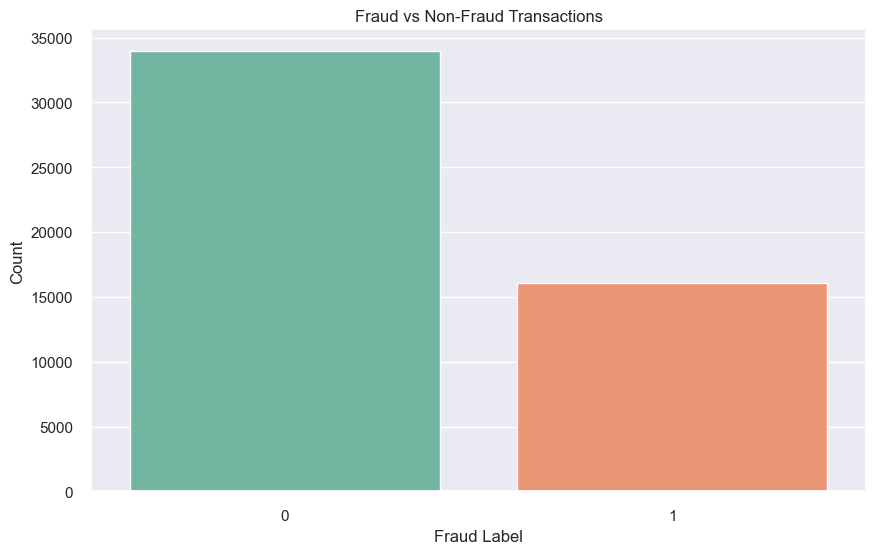

In [275]:
sns.countplot(x='Fraud_Label', data=df, palette='Set2')
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Fraud Label')
plt.ylabel('Count')
plt.show()


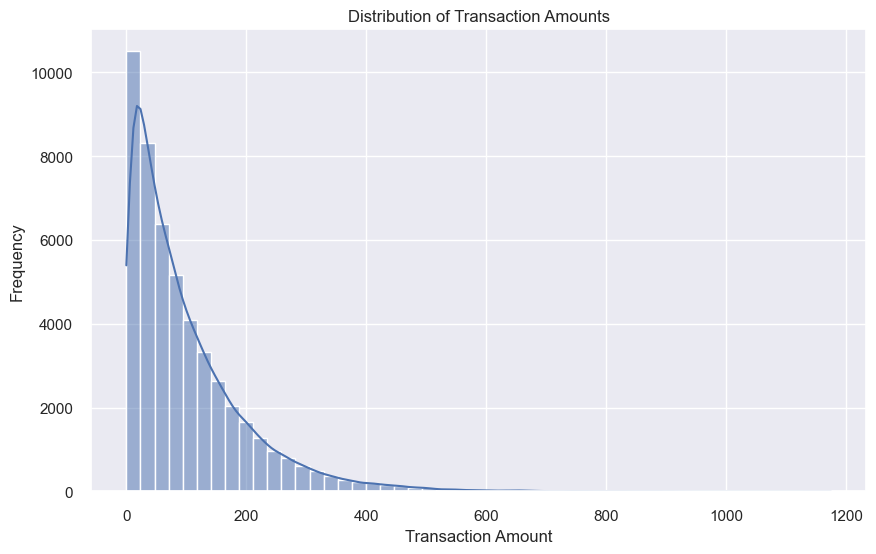

In [276]:
sns.histplot(df['Transaction_Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


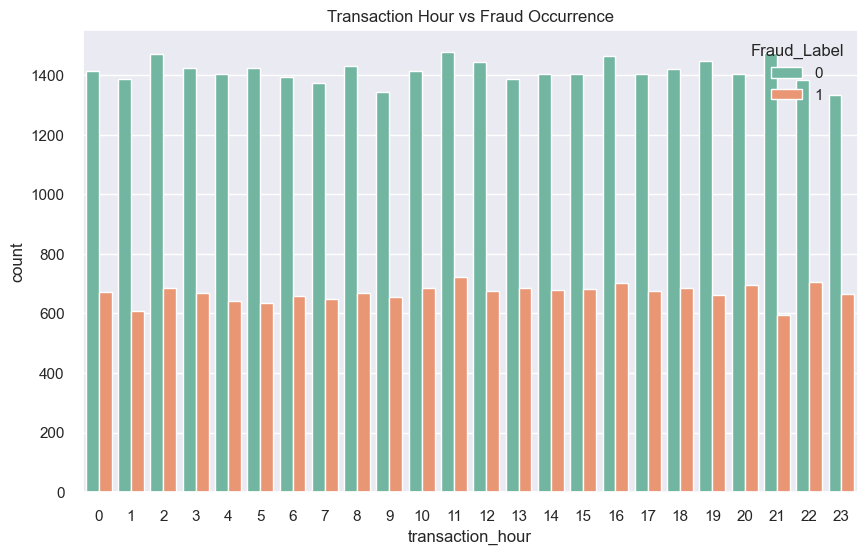

In [277]:
sns.countplot(x='transaction_hour', data=df, hue='Fraud_Label', palette='Set2')
plt.title('Transaction Hour vs Fraud Occurrence')
plt.show()


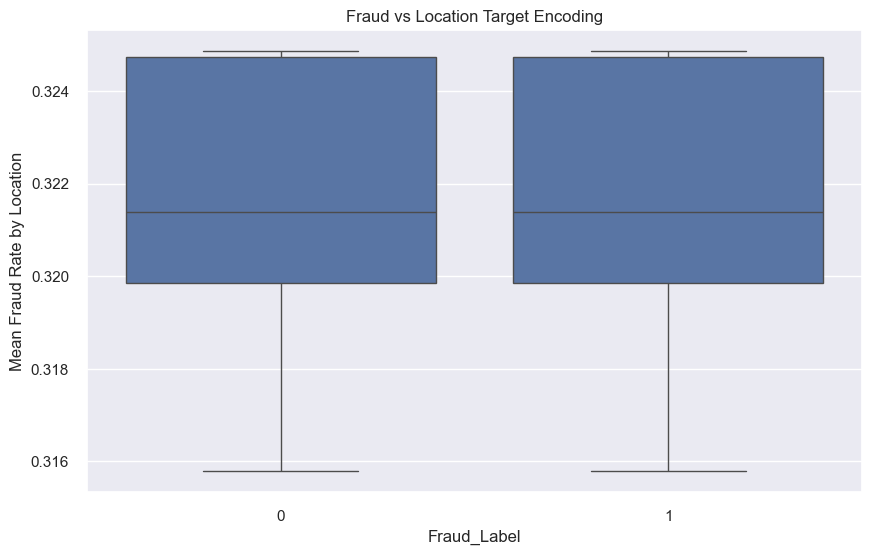

In [278]:
sns.boxplot(x='Fraud_Label', y='Location_TargetEnc', data=df)
plt.title('Fraud vs Location Target Encoding')
plt.ylabel('Mean Fraud Rate by Location')
plt.show()


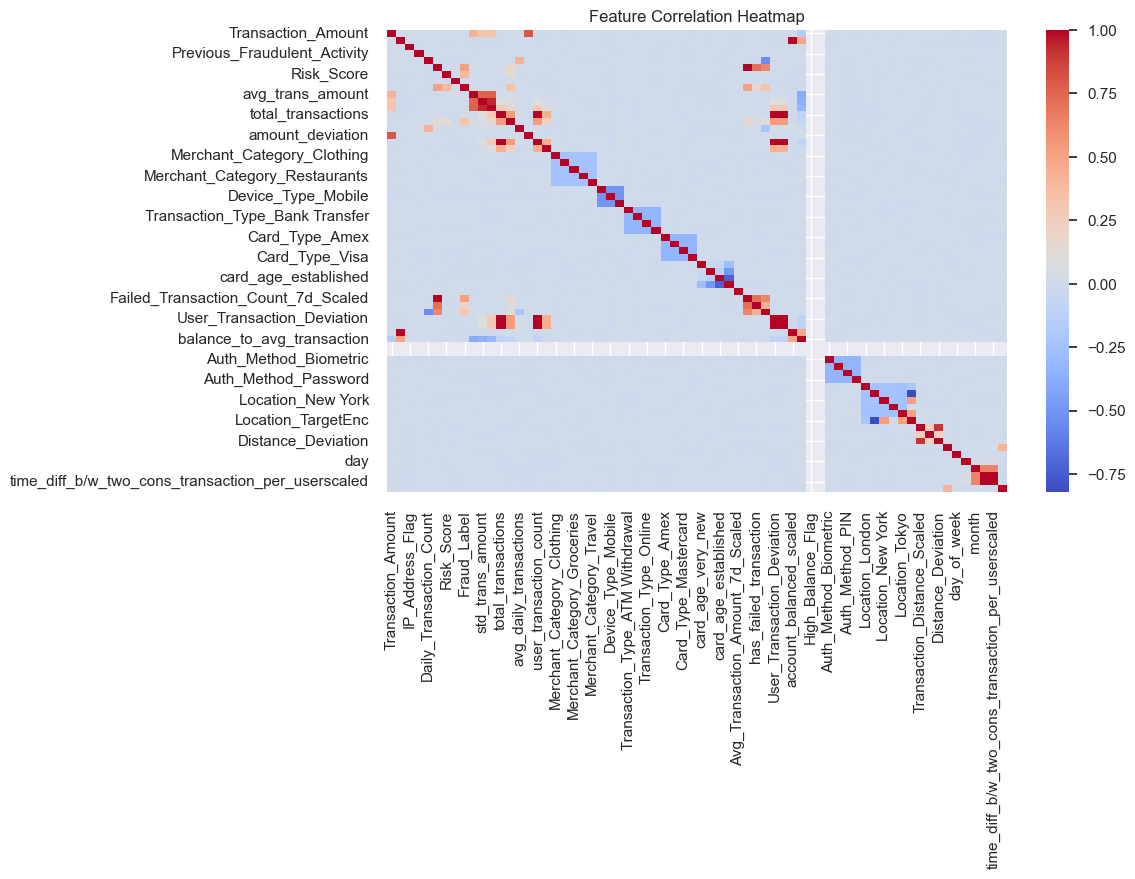

In [279]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


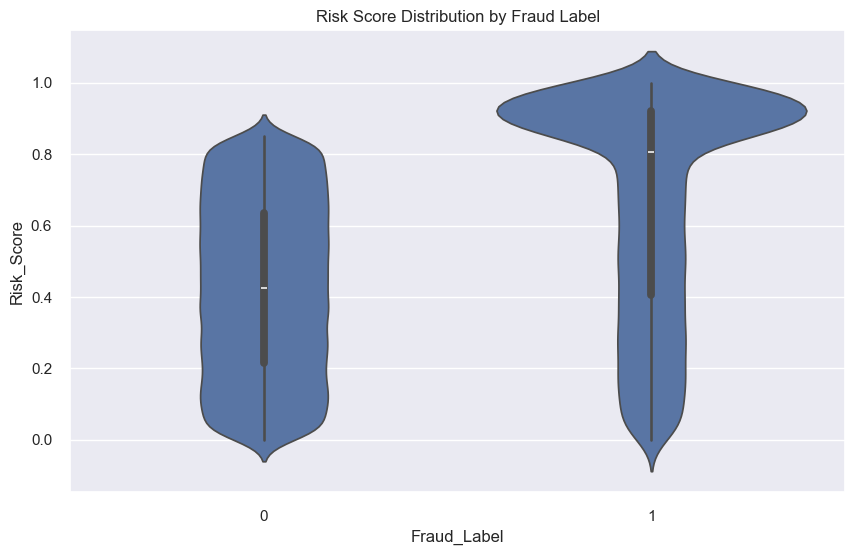

In [280]:
sns.violinplot(x='Fraud_Label', y='Risk_Score', data=df)
plt.title('Risk Score Distribution by Fraud Label')
plt.show()


#### **Baseline Model**

In [281]:
y=df['Fraud_Label']
X=df.drop('Fraud_Label', axis=1)

In [282]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [283]:
X_train.shape

(40000, 67)

In [284]:
from sklearn.preprocessing import StandardScaler

X_train_filled = X_train.fillna(X_train.mean())
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled = scaler.transform(X_test.fillna(X_train.mean()))

In [285]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
model1 = make_pipeline(StandardScaler(), 
                      LogisticRegression(max_iter=10000, solver='lbfgs'))
model1.fit(X_train_filled, y_train) # model training

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [286]:
prediction=model1.predict(X_test.fillna(X_train.mean())) # model prediction
prediction

array([0, 0, 0, ..., 1, 0, 0], shape=(10000,))

In [287]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(y_test, model1.predict(X_test.fillna(X_train.mean()))) * 100
print(f"Logistic Regression model accuracy: {acc:.2f}%")

Logistic Regression model accuracy: 86.08%


In [288]:
# confusion matrix
cm = confusion_matrix(y_test, prediction)
cm

array([[6132,  655],
       [ 737, 2476]])

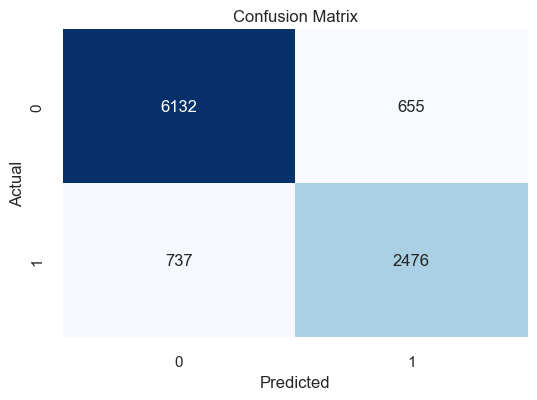

In [289]:
# visual representation of confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [290]:
from sklearn.metrics import classification_report, confusion_matrix


print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))


[[6132  655]
 [ 737 2476]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      6787
           1       0.79      0.77      0.78      3213

    accuracy                           0.86     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.86      0.86      0.86     10000



#### **Models**

In [296]:
leaky_features = [ 
    'total_fraud',
    'failurerate_7d',
    'has_failed_transaction',

    'Failed_Transaction_Count_7d_Scaled',
    'Failed_Transaction_Count_7d',


]

X_train_reduced = X_train.drop(columns=[f for f in leaky_features if f in X_train.columns])
X_test_reduced = X_test.drop(columns=[f for f in leaky_features if f in X_test.columns])


In [297]:
X_train_filled = X_train_reduced.fillna(X_train.mean())
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled = scaler.transform(X_test_reduced.fillna(X_test_reduced.mean()))

In [298]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),  
    'NaiveBayes': GaussianNB(),

}

In [299]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}


for i in models:
    obj = models[i]
    obj.fit(X_train_scaled, y_train)
    obj_pred = obj.predict(X_test_scaled)

 
    accuracy = accuracy_score(y_test, obj_pred>0.5,)
    precision = precision_score(y_test, obj_pred>0.5,average='weighted')
    recall = recall_score(y_test, obj_pred>0.5,average='weighted')
    f1 = f1_score(y_test, obj_pred>0.3,average='weighted')

  
    results['Model'].append(i)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)


results_df = pd.DataFrame(results)


print(results_df)

                Model  Accuracy  Precision  Recall  F1-Score
0  LogisticRegression    0.7927   0.788358  0.7927  0.780468
1        DecisionTree    0.7179   0.725263  0.7179  0.720958
2        RandomForest    0.8319   0.865270  0.8319  0.811386
3                 KNN    0.6533   0.613781  0.6533  0.619689
4                 SVM    0.7963   0.795777  0.7963  0.781097
5          NaiveBayes    0.7385   0.730500  0.7385  0.732951


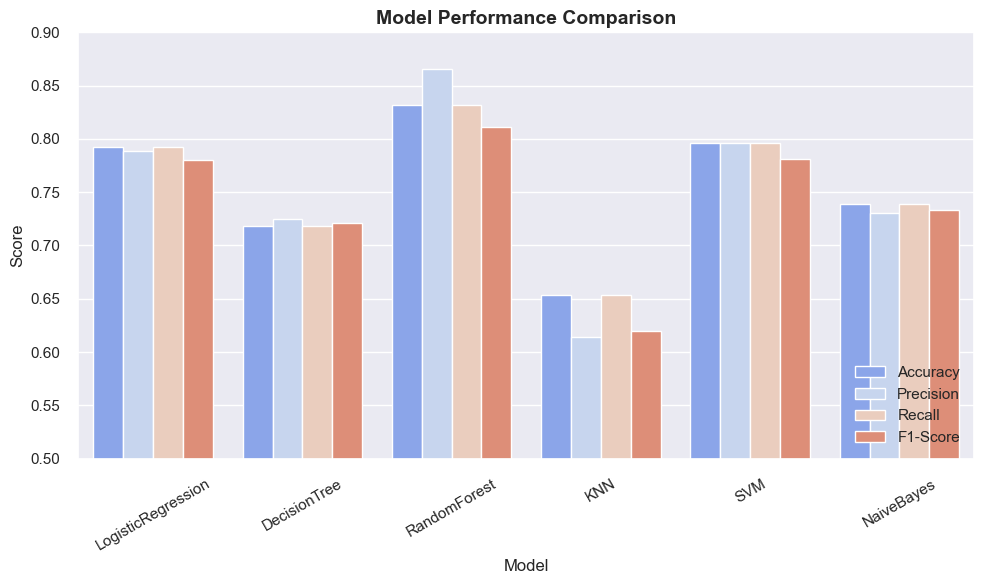

In [311]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


data = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVM', 'NaiveBayes'],
    'Accuracy': [0.7927, 0.7179, 0.8319, 0.6533, 0.7963, 0.7385],
    'Precision': [0.788358, 0.725263, 0.865270, 0.613781, 0.795777, 0.730500],
    'Recall': [0.7927, 0.7179, 0.8319, 0.6533, 0.7963, 0.7385],
    'F1-Score': [0.780468, 0.720958, 0.811386, 0.619689, 0.781097, 0.732951]
}
df = pd.DataFrame(data)


plt.figure(figsize=(10,6))
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='coolwarm')

plt.title("Model Performance Comparison", fontsize=14, weight='bold')
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0.5, 0.9)
plt.legend(loc='lower right')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


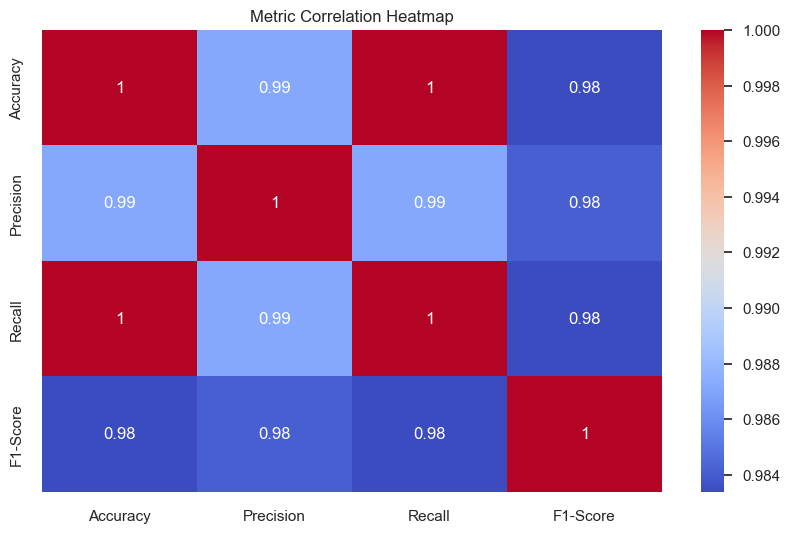

In [305]:
sns.heatmap(df.iloc[:, 1:].corr(), annot=True, cmap='coolwarm')
plt.title("Metric Correlation Heatmap")
plt.show()


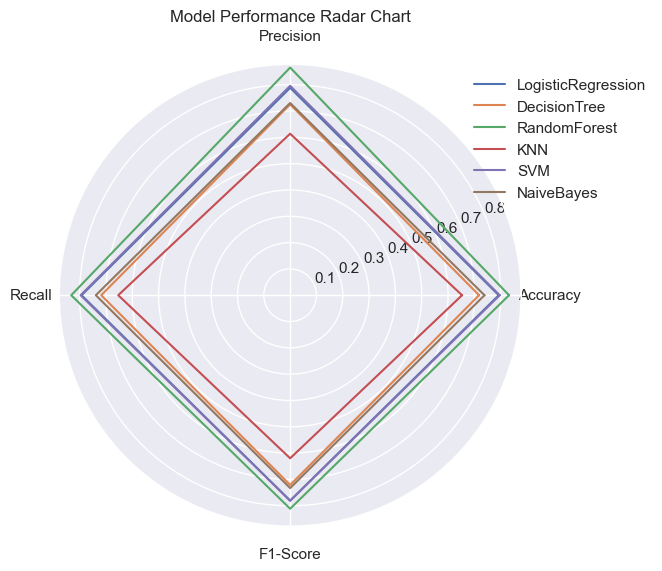

In [307]:
import numpy as np
from math import pi

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(metrics)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1] 

plt.figure(figsize=(6,6))

for i, row in df.iterrows():
    values = row[1:].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row['Model'])

plt.xticks(angles[:-1], metrics)
plt.title("Model Performance Radar Chart")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


In [300]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
bnb = BernoulliNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'binarize': [0.0, 0.5, 1.0, 1.5, 2.0]
}

grid_search = GridSearchCV(estimator=bnb, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


best_nb = grid_search.best_estimator_
y_pred = best_nb.predict(X_test_scaled)


print(classification_report(y_test, y_pred))

Best parameters found:  {'alpha': 0.1, 'binarize': 1.0}
Best Accuracy: 0.7940250000000001
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      6787
           1       0.78      0.52      0.62      3213

    accuracy                           0.80     10000
   macro avg       0.79      0.73      0.74     10000
weighted avg       0.80      0.80      0.79     10000



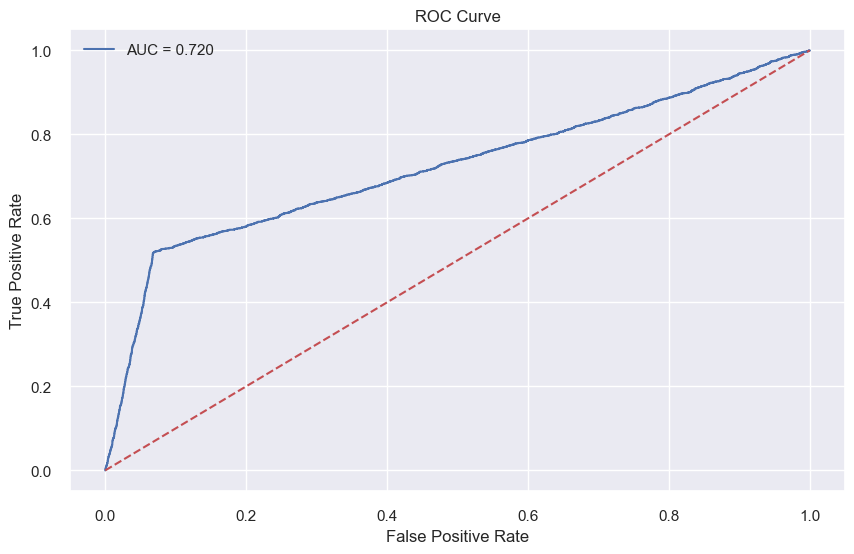

In [310]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = grid_search.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [313]:
import joblib

best_model = RandomForestClassifier()
best_model.fit(X_train_scaled, y_train)


joblib.dump(best_model, 'model.pkl')
print(" Model saved as model.pkl")


 Model saved as model.pkl


|--- Failed_Transaction_Count_7d_Scaled <= 0.88
|   |--- Risk_Score <= 0.85
|   |   |--- class: 0
|   |--- Risk_Score >  0.85
|   |   |--- class: 1
|--- Failed_Transaction_Count_7d_Scaled >  0.88
|   |--- class: 1



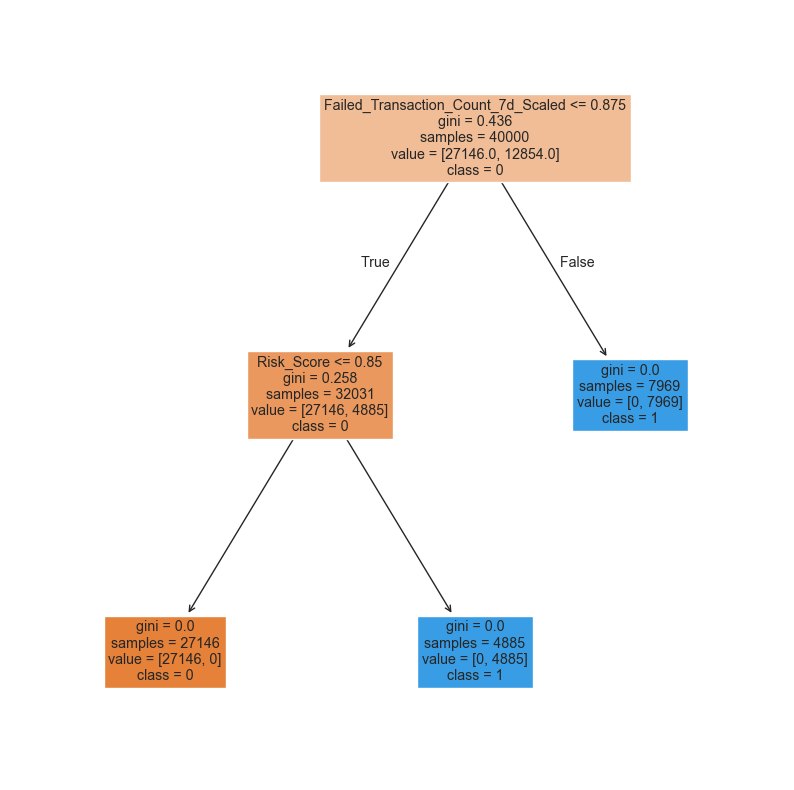

In [323]:
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

model = models['DecisionTree']
model.fit(X_train, y_train)


print(export_text(model, feature_names=list(X_train.columns)))


plt.figure(figsize=(10,10))
plot_tree(model, feature_names=X_train.columns, class_names=['0','1'], filled=True)
plt.show()


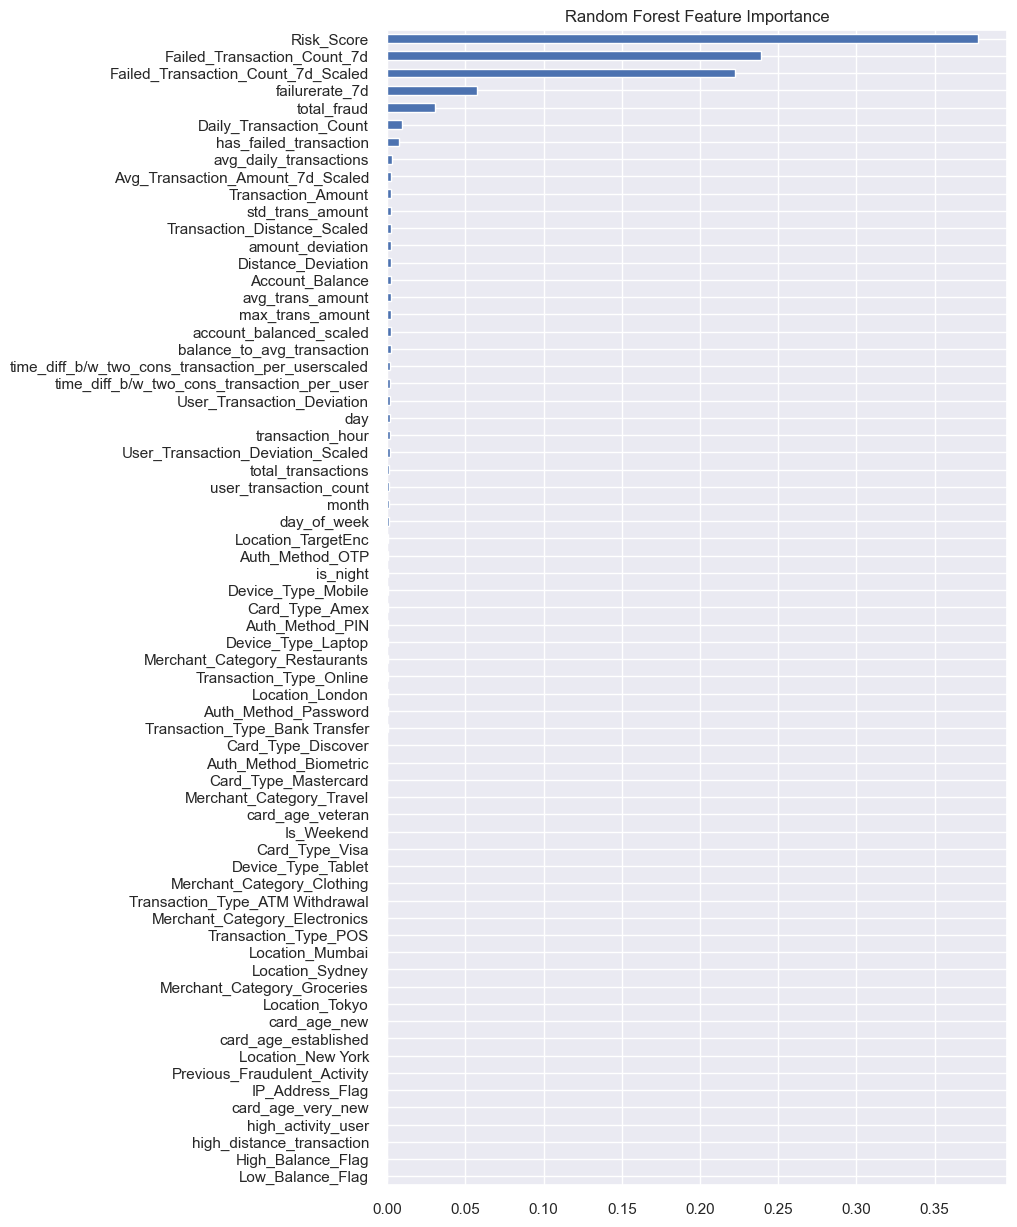

In [324]:
model = models['RandomForest']
model.fit(X_train, y_train)

import pandas as pd
import matplotlib.pyplot as plt

feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.sort_values().plot(kind='barh', figsize=(8,15))
plt.title("Random Forest Feature Importance")
plt.show()
